In [3]:
import sys
sys.path.append('/root/PLgpt-circuits')

In [75]:
from models.sparsified import SparsifiedGPTOutput, SparsifiedGPT
import torch as t
from config.gpt.training import options
from config.sae.models import sae_options

import matplotlib.pyplot as plt

from data.tokenizers import ASCIITokenizer, TikTokenTokenizer

from models.sae import SparseAutoencoder
from typing import Callable

from data.dataloaders import TrainingDataLoader

In [13]:
path = '../checkpoints/'

In [20]:
SparsifiedGPT.load(path + 'SLRAE-rank0')

SparsifiedGPT(
  (gpt): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(128, 64)
      (wpe): Embedding(128, 64)
      (h): ModuleList(
        (0-3): 4 x Block(
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=64, out_features=192, bias=True)
            (c_proj): Linear(in_features=64, out_features=64, bias=True)
          )
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=64, out_features=256, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=256, out_features=64, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=64, out_features=128, bias=False)
  )
  (saes): ModuleDict(
    (0): StandardSLRAE()
    (1): StandardSLRAE()
    (2): StandardSLRAE()
  

In [17]:
SLRAES = {}

In [21]:
for i in range(10):
    SLRAES[i] = SparsifiedGPT.load(path + f'SLRAE-rank{i}')

In [38]:
for i in range(10):
    SLRAES[i].to(SLRAES[i].config.device)

In [24]:
SLRAES[0].config.block_size

128

In [30]:

block_size = SLRAES[0].config.block_size
batch_size = 32
data_dir = '../data/shakespeare'



#copied from Peter's training code
ddp = int(os.environ.get("RANK", -1)) != -1  # is this a ddp run?
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    ddp_rank = int(os.environ["RANK"])
    ddp_local_rank = int(os.environ["LOCAL_RANK"])
    ddp_world_size = int(os.environ["WORLD_SIZE"])
    device = t.device(f"cuda:{ddp_local_rank}")

    assert t.cuda.is_available()
    t.cuda.set_device(device)
else:
    # vanilla, non-DDP run
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    device = SLRAES[0].config.device

dataloader = TrainingDataLoader(
    dir_path=data_dir,
    B= batch_size,
    T=block_size,
    process_rank=ddp_rank,
    num_processes=ddp_world_size,
    split="val",
)

Found 1 shards for split val


In [50]:
x,y = dataloader.next_batch(device)

In [35]:
SLRAES[0].config.device

device(type='cuda')

In [36]:
SLRAES[0].to(SLRAES[0].config.device)

SparsifiedGPT(
  (gpt): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(128, 64)
      (wpe): Embedding(128, 64)
      (h): ModuleList(
        (0-3): 4 x Block(
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=64, out_features=192, bias=True)
            (c_proj): Linear(in_features=64, out_features=64, bias=True)
          )
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=64, out_features=256, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=256, out_features=64, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=64, out_features=128, bias=False)
  )
  (saes): ModuleDict(
    (0): StandardSLRAE()
    (1): StandardSLRAE()
    (2): StandardSLRAE()
  

In [47]:
target = SLRAES[0].forward(x.long(), targets=None, is_eval=False)

In [60]:
out = SLRAES[0].forward(x.long(), targets = y, is_eval = True)

In [124]:
CE_losses = t.zeros(10)
L1s = t.zeros((10, 5))

for rank in range(10):
    CE_losses[rank] = 0
numsamples = 500
for _ in range(numsamples):
    x,y = dataloader.next_batch(device)
    for rank in range(10):
        out = SLRAES[rank].forward(x.long(), targets = y, is_eval = True)
        CE_losses[rank] += out.compound_ce_loss_increase.item()
        for layer in range(5):
            L1s[rank, layer] += out.feature_magnitudes[layer].sum().item()


In [83]:
out.feature_magnitudes[0].shape

torch.Size([32, 128, 512])

In [125]:
L1s = L1s/(32*numsamples*128)

In [126]:
CE_losses = CE_losses/numsamples

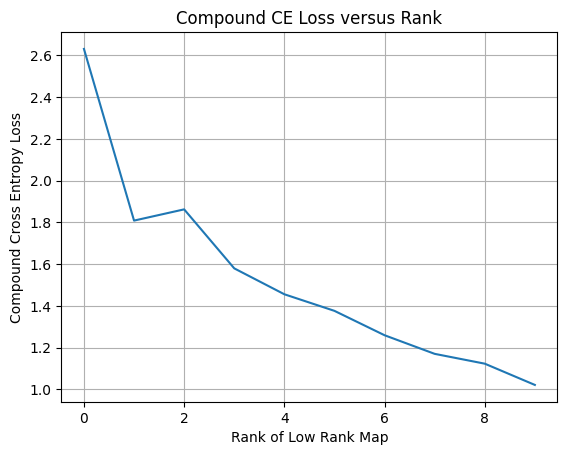

In [127]:
# Plot it
plt.plot(CE_losses.numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel("Compound Cross Entropy Loss")
plt.title("Compound CE Loss versus Rank")
plt.grid(True)
plt.show()

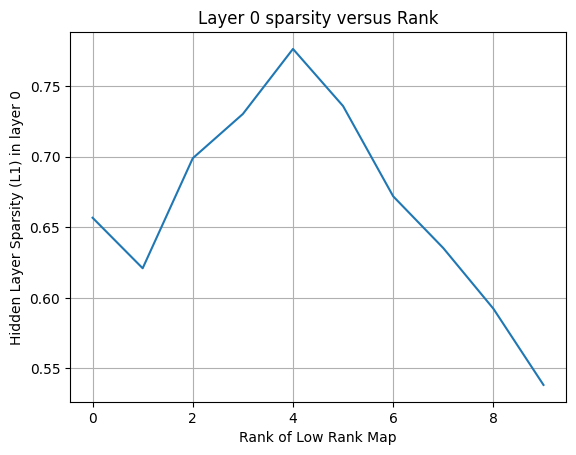

In [128]:
# Plot it

layer = 0
plt.plot(L1s[:,layer].numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel(f"Hidden Layer Sparsity (L1) in layer {layer}")
plt.title(f"Layer {layer} sparsity versus Rank")
plt.grid(True)
plt.show()

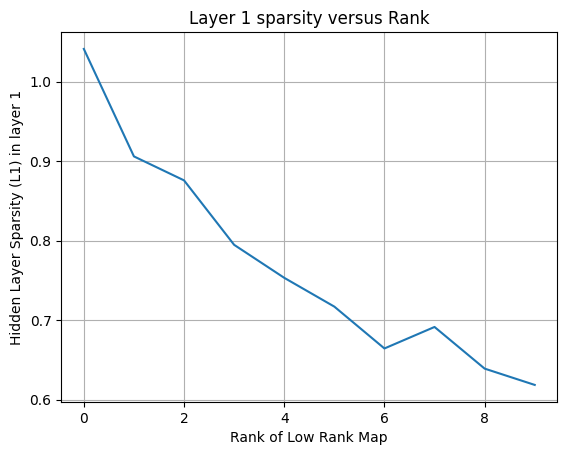

In [129]:
layer = 1
plt.plot(L1s[:,layer].numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel(f"Hidden Layer Sparsity (L1) in layer {layer}")
plt.title(f"Layer {layer} sparsity versus Rank")
plt.grid(True)
plt.show()

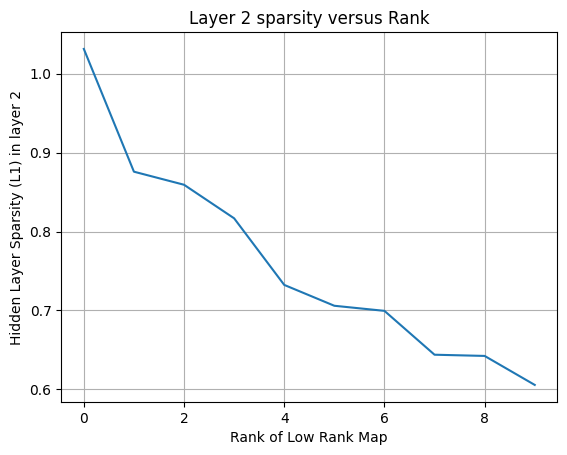

In [130]:
layer = 2
plt.plot(L1s[:,layer].numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel(f"Hidden Layer Sparsity (L1) in layer {layer}")
plt.title(f"Layer {layer} sparsity versus Rank")
plt.grid(True)
plt.show()

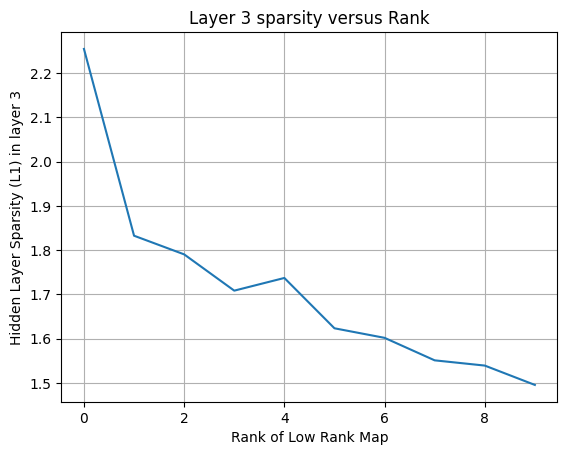

In [131]:
layer = 3
plt.plot(L1s[:,layer].numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel(f"Hidden Layer Sparsity (L1) in layer {layer}")
plt.title(f"Layer {layer} sparsity versus Rank")
plt.grid(True)
plt.show()

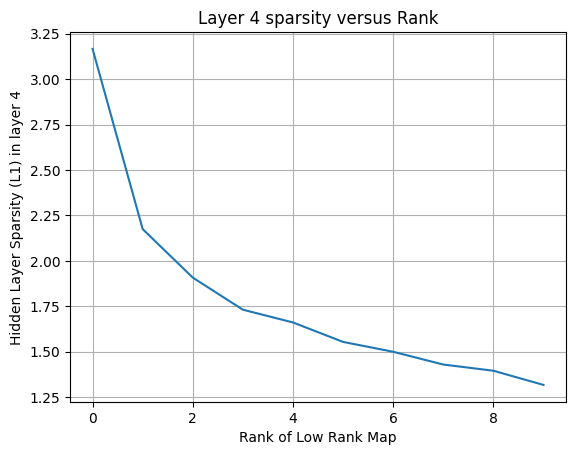

In [132]:
layer = 4
plt.plot(L1s[:,layer].numpy())  # Use numpy() to convert for matplotlib
plt.xlabel("Rank of Low Rank Map")
plt.ylabel(f"Hidden Layer Sparsity (L1) in layer {layer}")
plt.title(f"Layer {layer} sparsity versus Rank")
plt.grid(True)
plt.show()

Okay, now let's check large rank bounds, for sanity

In [92]:
for i in [30,60,64]:
    SLRAES[i] = SparsifiedGPT.load(path + f'SLRAE-rank{i}')

In [93]:
for i in [30,60,64]:
    SLRAES[i].to(SLRAES[i].config.device)

In [95]:
high_ranks = [30,60,64]
High_rank_CE_losses = {30:0,60:0,64:0}
High_rank_L1s = {}
for r in high_ranks:
    High_rank_L1s[r] = t.zeros(5)

numsamples = 100
for _ in range(numsamples):
    x,y = dataloader.next_batch(device)
    for rank in high_ranks:
        out = SLRAES[rank].forward(x.long(), targets = y, is_eval = True)
        High_rank_CE_losses[rank] += out.compound_ce_loss_increase.item()
        for layer in range(5):
            High_rank_L1s[rank][layer] += out.feature_magnitudes[layer].sum().item()

In [99]:
for rank in high_ranks:
    High_rank_CE_losses[rank] = High_rank_CE_losses[rank]/100

In [100]:
High_rank_CE_losses

{30: 0.2025739634037018, 60: 0.020571634769439698, 64: 0.00037203192710876464}

In [102]:
High_rank_L1s[30]/(32*100*128)

tensor([0.1499, 0.1665, 0.1807, 0.8815, 0.5227])

In [104]:
High_rank_L1s[60]/(32*100*128)

tensor([0.0116, 0.0055, 0.0027, 0.1232, 0.0098])

In [105]:
High_rank_L1s[64]/(32*100*128)

tensor([2.3214e-08, 2.5806e-05, 2.2298e-06, 1.1773e-04, 2.8840e-04])